In [8]:
import cv2 as cv
import shutil
import os
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import pandas as pd

In [9]:
mypath = 'train'

classes = [str(i).zfill(3) for i in range(0, 60)]

files = [f for f in listdir(mypath) if isfile(join(mypath, f))]
files = [f for f in files if f.endswith('.png')]

for i in range(len(files)):
    if files[i][:3] in classes:
        
        # create a folder for each class
        folderName = files[i][:3]
        if folderName == '000': folderName = mypath + '/' + '0'
        else: folderName = mypath + '/' + folderName.lstrip('0')
        if not os.path.exists(folderName): os.mkdir(folderName)
        
        # move the file to the corresponding folder
        shutil.move(mypath + '/' + files[i], folderName + '/' + files[i])


In [10]:
# remove .DS_Store file
if os.path.exists(mypath + '/.DS_Store'):
    os.remove(mypath + '/.DS_Store')

# Load images
count = 0
images = []
classNo = []
folder = os.listdir(mypath)
classes=len(folder)
for x in range (0,len(folder)):
    files = os.listdir(mypath+"/"+str(count))
    for y in files:
        curImg = cv.imread(mypath+"/"+str(count)+"/"+y)
        images.append(curImg)
        classNo.append(count)
    count +=1
images = np.array(images)
classNo = np.array(classNo)


/var/folders/xh/sz1h2s3x03j0v5dn75bshdz00000gp/T/ipykernel_88072/307641171.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  images = np.array(images)


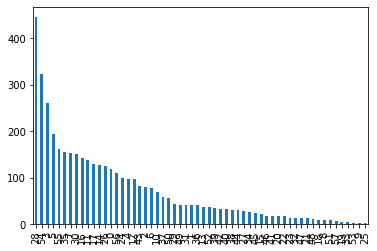

In [11]:
# convert text file to csv file

textFile = 'TsignRecgTrain4170Annotation.txt'
csvFile = 'TSDR_Labels.csv'

header = ['filename', 'width', 'height', 'x1', 'y1', 'x2', 'y2', 'class']
df = pd.read_csv(textFile, sep=';', header=None, index_col=False, names=header)
df.to_csv(csvFile, index=False)

# remove duplicate rows
df = df.drop_duplicates(subset=['filename', 'class'], keep='first')
df.to_csv(csvFile, index=False)

# get the number of images per class
# plot a table of the number of images per class
df['class'].value_counts().plot(kind='bar')
plt.show()

In [19]:
def red_mask(img):
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    low_lower_red = np.array([0, 100, 20])
    low_upper_red = np.array([10, 255, 255])

    high_lower_red = np.array([160, 100, 20])
    high_upper_red = np.array([179, 255, 255])

    red_low = cv.inRange(hsv, low_lower_red, low_upper_red)
    red_high = cv.inRange(hsv, high_lower_red, high_upper_red)

    red_mask = red_low + red_high
    return red_mask


def blue_mask(img):
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    lower_blue = np.array([100, 100, 20])
    upper_blue = np.array([140, 255, 255])

    blue_mask = cv.inRange(hsv, lower_blue, upper_blue)
    return blue_mask


def yellow_mask(img):
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    lower_yellow = np.array([10, 80, 20])
    upper_yellow = np.array([50, 255, 255])

    yellow_mask = cv.inRange(hsv, lower_yellow, upper_yellow)
    return yellow_mask


def hsv_range_threshold(img):
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    red = red_mask(img)
    blue = blue_mask(img)
    yellow = yellow_mask(img)
    
    mask =  red + blue + yellow
    result = cv.bitwise_and(rgb, rgb, mask=mask)
    return mask


# def hsv_range_threshold(img):
#     # convert to hsv
#     hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)

#     # hsv = cv.medianBlur(hsv, 5)
#     # hsv = cv.bilateralFilter(hsv, 9, 75, 75)

#     red = hsv.copy()

#     # lower boundary RED color range values; 
#     red_lower1 = np.array([0, 100, 20], dtype=np.uint8)
#     red_upper1 = np.array([10, 255, 255], dtype=np.uint8)

#     # upper boundary RED color range values; 
#     red_lower2 = np.array([160,100,20], dtype=np.uint8)
#     red_upper2 = np.array([179,255,255], dtype=np.uint8)

#     red_lower_mask = cv.inRange(hsv, red_lower1, red_upper1)
#     red_upper_mask = cv.inRange(hsv, red_lower2, red_upper2)
#     red = red_lower_mask + red_upper_mask;

#     blue = hsv.copy()

#     # lower boundary BLUE color range values;
#     blue_lower = np.array([100, 100, 20], dtype=np.uint8)
#     blue_upper = np.array([140, 255, 255], dtype=np.uint8)
#     blue = cv.inRange(hsv, blue_lower, blue_upper)

#     yellow = hsv.copy()

#     # lower boundary yellow color range values 
#     yellow_lower = np.array([10, 80, 20], dtype=np.uint8)
#     yellow_upper = np.array([50, 255, 255], dtype=np.uint8)
#     yellow = cv.inRange(hsv, yellow_lower, yellow_upper)
    
#     # combine the three thresholds
#     thresh = cv.bitwise_or(red, blue, yellow)
#     return thresh




def hsv_threshold(img):
    # convert to hsv
    hsv = cv.cvtColor(test_img, cv.COLOR_BGR2HSV)

    hsv = cv.medianBlur(hsv, 5)
    hsv = cv.bilateralFilter(hsv, 9, 75, 75)
    kernel = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])

    h,s,v = cv.split(hsv)

    # otsu thresholding
    ret, h_thresh = cv.threshold(h, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    ret, s_thresh = cv.threshold(s, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

    thresh = cv.bitwise_and(h_thresh, s_thresh)


    # erosion and dilation
    kernel_e = np.ones((3,3), np.uint8)
    thresh = cv.erode(thresh, kernel_e, iterations=1)
    thresh = cv.dilate(thresh, kernel_e, iterations=1)

    # open 
    kernel = np.ones((1,1), np.uint8)
    thresh = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel)

    # fill holes in the thresholded image
    return cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel)

def get_box(img, thresh):
    height = test_img.shape[0]
    width = test_img.shape[1]
    contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    idx = 0
    max_area = -1
    
    if len(contours) < 1:
        return None
    
    for i in range(len(contours)):
        area = cv.contourArea(contours[i])
        x,y,w,h = cv.boundingRect(contours[i])
        # remove if height or width is almost the same as the image
        if area > max_area and x>0 and y>0 and w>0 and h>0 and w<width and h<height:
            max_area = area
            if contours[i] is not None:
                idx = i

    return contours[idx]

def compare_threshold(test_img, range_thresh, hsv_thresh, and_thresh):
    # compare the two thresholds
    th = [range_thresh, hsv_thresh, and_thresh]
    contours = []
    
    # inverted threshold
    for i in range(len(th)):
        inv = cv.bitwise_not(th[i])
        inv_erode = cv.erode(inv, np.ones((3,3), np.uint8), iterations=1)
        inv_dilate = cv.dilate(inv_erode, np.ones((3,3), np.uint8), iterations=1)
        inv_close = cv.morphologyEx(inv_dilate, cv.MORPH_CLOSE, np.ones((3,3), np.uint8))
        th.append(inv_close)
        
    for i in range(len(th)):
        cnts = get_box(test_img, th[i])
        if cnts is not None:
            contours.append(cnts)

    # get the bounding box of the largest contour
    area = 0
    height = test_img.shape[0]
    width = test_img.shape[1]
    largest_contour = None
    for i in range(len(contours)):
        x, y, w, h = cv.boundingRect(contours[i])
        if (cv.contourArea(contours[i]) > area) and cv.contourArea(contours[i]) < height*width*0.9:
            # if the contour is not touching the edge of the image
            if (y > 0 or x > 0) and (y + h < height-1 or x + w < width-1):
                # if the ratio of the contour is within the range
                if (w/h > 0.5 and w/h < 1.5):
                    area = cv.contourArea(contours[i])
                    largest_contour = contours[i]
        
    x, y, w, h = cv.boundingRect(largest_contour)
    cv.rectangle(test_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    return test_img


def plot_image(img, title, i):
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.xticks([])
    plt.show()
    

Image ID = 557
Image Class = 4
Time to process this codes (ms):  6.622076034545898


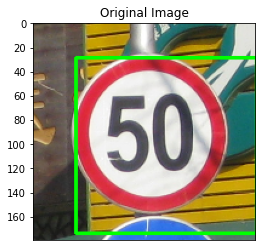

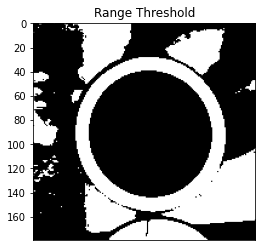

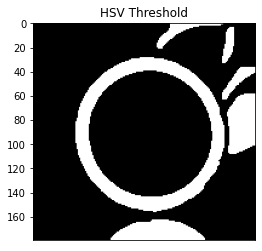

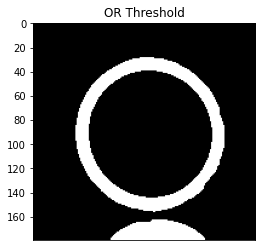

In [77]:
# get the time to process this codes
import time
start_time = time.time()

# randomly select and image
idx = np.random.randint(0, len(images)-1)
test_img = images[idx].copy()
print(f"Image ID = {idx}")
print(f"Image Class = {classNo[idx]}")

range_thresh = hsv_range_threshold(test_img)
hsv_thresh = hsv_threshold(test_img)
or_thresh = cv.bitwise_and(range_thresh, hsv_thresh)
or_thresh = cv.morphologyEx(or_thresh, cv.MORPH_CLOSE, np.ones((3,3), np.uint8))

result = compare_threshold(test_img, range_thresh, hsv_thresh, or_thresh)


# get the time to process this codes
end_time = time.time()
print("Time to process this codes (ms): ", (end_time - start_time)*1000)

plot_image(cv.cvtColor(result, cv.COLOR_BGR2RGB), "Original Image", 0)
plot_image(range_thresh, "Range Threshold", 2)
plot_image(hsv_thresh, "HSV Threshold", 3)
plot_image(or_thresh, "OR Threshold", 4)

# accuracy
